In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('bmh')
import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run, standard_substitutes
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

[03/09/23 15:16:40] WARNING  Using NumPy C-API based implementation for BLAS functions.        ]8;id=64234;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py\blas_headers.py]8;;\:]8;id=742504;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py#1016\1016]8;;\

In [3]:
import sympy as sp
from symseaman.seaman_symbols import *
from symseaman.substitute_dynamic_symbols import run, lambdify, standard_substitutes, remove_bis, remove_bis_eq, standard_substitutes_eq, lower_and_abs
from symseaman.seaman_symbol import BisSymbol
import symseaman as ss
from symseaman.seaman_symbol import expand_bis
from symseaman.shipdict import ShipDict
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 4 
plt.style.use('bmh')
import vct.bokeh_plotting as bokeh_plotting
from numpy.testing import assert_almost_equal
from scipy.interpolate import interp1d
from symseaman.calculate import calculate_ship
from symseaman.to_matrix import matrix_form, matrix_form_standard, exclude, exclude_derivatives
from functools import reduce
from operator import add
from vct.regression_ols import Regression, RegressionPipeline
import dill

Loading BokehJS ...

In [4]:
# Read configs:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]
from vct.bis_system import BisSystem
import statsmodels.api as sm
from scipy.stats import norm

In [129]:
%reload_kedro
ship_name=ships[0]
shipdict = catalog.load(f"{ship_name}.shipdict_base")
ship_dict_from_regression = catalog.load(f"{ ship_name }.ship_dict_from_regression")

df_VCT = catalog.load(f"{ship_name}.df_VCT")
df_VCT['g'] = df_VCT['g'].fillna(method='pad')
df_VCT['rho'] = df_VCT['rho'].fillna(method='pad')

thrust_keys = catalog.load(f"params:{ship_name}.thrust_keys")

if len(thrust_keys) > 0:
    df_VCT['tprop'] = df_VCT[thrust_keys[0]]
else:
    df_VCT['tprop'] = 0
    thrust_keys=['tprop']
    
derivatives = catalog.load(f"{ship_name}.derivatives")["OLS"]
derivatives_std = catalog.load(f"{ship_name}.derivatives_std")["OLS"]

[03/09/23 16:18:58] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=471361;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=839230;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/09/23 16:18:59] INFO     Kedro project phd                                                      ]8;id=865815;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=413741;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=856877;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=251788;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.shipdict_base' (ShipDictDataSet)...  ]8;id=526758;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=233556;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.ship_dict_from_regression'           ]8;id=725165;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=151981;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=322233;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=37590;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:M5064-02-A.thrust_keys'                  ]8;id=416568;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=767228;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'M5064-02-A.derivatives' (IncrementalDataSet)... ]8;id=295415;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=31962;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.derivatives_std'                     ]8;id=985888;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=673951;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

In [130]:
lpp_ = shipdict.main_data['l']
t_ = shipdict.design_particulars['ta']
disp_ = shipdict.design_particulars['disp']
units={'fy_rudders':'force',
       'fy_rudder':'force',
       'tprop':'force',
      }
bis_system = BisSystem(lpp=lpp_, volume=disp_, units=units)

interesting = list((set(bis_system.qd.keys()) & set(df_VCT.columns)) |  (set(df_VCT.columns) & set(['test type', 'model_name','fy_rudders','fy_rudder','tprop'])))
interesting = list(set(interesting))
df_bis = bis_system.df_to_bis(df_VCT[interesting])

### $Y_{T\delta}$

In [131]:
class Regression_ytd(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (v_w.bis,0),
    #(Y_uudelta, 0),
    ])
    intercept=False

In [132]:
pre_set_derivatives_0 = {
    's':shipdict.rudder_coeff_data['s'],
    'kv':shipdict.rudder_coeff_data['kv'],
    'kr':shipdict.rudder_coeff_data['kr'],
    'ktyh':derivatives['ktyh'],
    'xxprop':derivatives['xxprop'],
}
pipeline = RegressionPipeline(shipdict=shipdict, pre_set_derivatives=pre_set_derivatives_0)

mask = df_bis['test type'].isin(['Thrust variation','Rudder angle'])
df_ = df_bis.loc[mask]

pipeline['ytd'] = Regression_ytd(df=df_)

In [133]:
regression = pipeline['ytd']

In [134]:
y,X=regression.label_and_features(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

In [135]:
X

,yuud,ytd
24,-0.010023,-0.001570
25,-0.019281,-0.003054
26,-0.027007,-0.004347
27,-0.032435,-0.005314
28,-0.034799,-0.005847
29,-0.027272,-0.004805
30,0.027007,0.000658
31,0.027007,0.001587
32,0.027007,0.005880
33,0.027007,0.007722


In [136]:
regression.fit(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

In [137]:
data = df_
basic_model = pm.Model()

columns = list(X.columns)

sigmas_ = [derivatives_std[key] for key in columns]
mus_ = [derivatives[key] for key in columns]
sigma_ = 0.001*data['fy'].abs().max()

with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(columns))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=y)
    #ν = pm.Uniform("ν", 1, 10)
    #Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=y)

In [138]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(draws=1000)

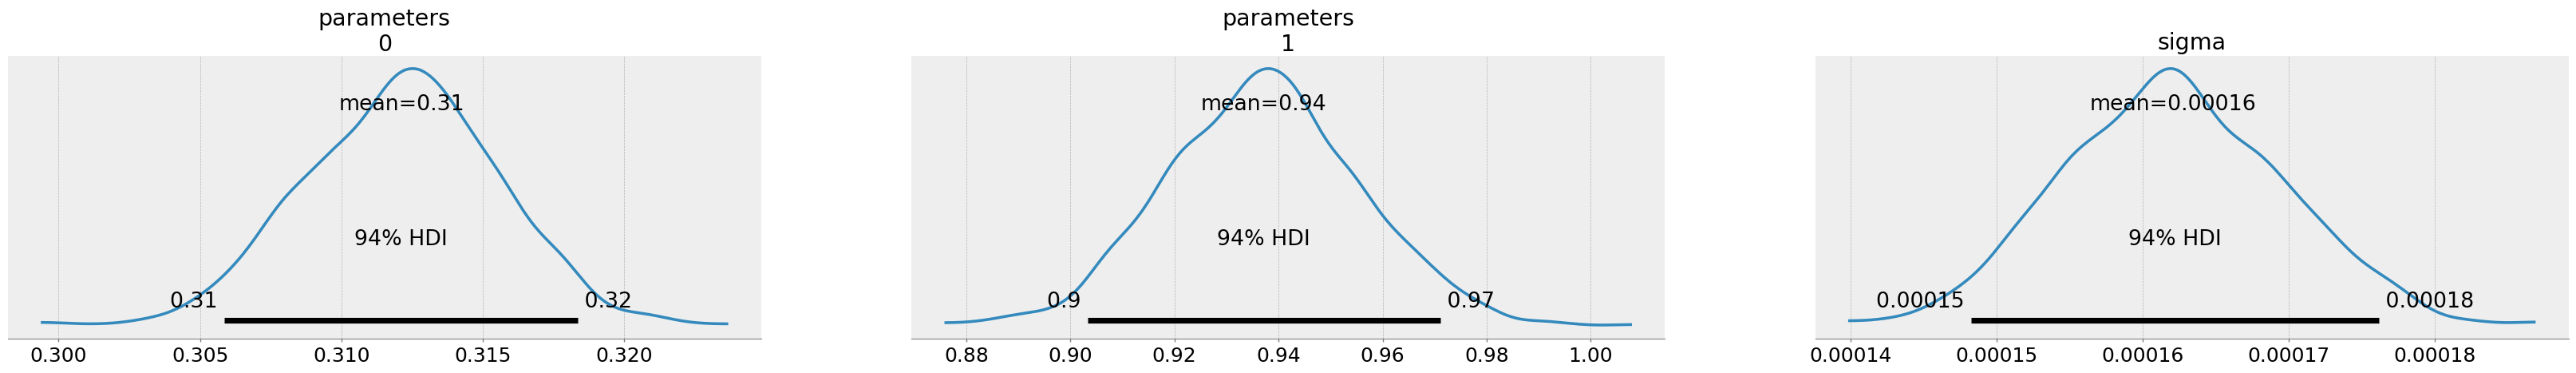

In [139]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=18,
                  point_estimate='mean',
                  rope_color='black')

In [140]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.312,0.003,0.306,0.318,0.000,0.0,1032.0,1080.0,1.0
parameters[1],0.937,0.019,0.903,0.971,0.001,0.0,1113.0,1136.0,1.0
sigma,0.000,0.000,0.000,0.000,0.000,0.0,1390.0,999.0,1.0


In [141]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [142]:
means

{'yuud': 0.31214190788496304, 'ytd': 0.9370990041331868}

In [109]:
stds = (trace.posterior['parameters'].data[0].std(axis=0) + trace.posterior['parameters'].data[1].std(axis=0))/2
stds = {key:std for key,std in zip(columns,stds)}

In [110]:
stds

{'yuud': 0.0031845422476200853, 'ytd': 0.017189017943379202}

In [113]:
regression.regression.bse['ytd']

0.10152269963551566

In [114]:
regression.regression.bse['yuud']

0.01756717765118333

In [115]:
derivatives_std['ytd']

0.027810339140150346

In [116]:
derivatives_std['yuud']

0.010963414742204972

In [111]:
df_parameters = pd.concat([
pd.Series(means, name='Bayesian'),
pd.Series({key:derivatives[key] for key in means.keys()}, name='splitted OLS'),
pd.Series({key:regression.regression.params[key] for key in means.keys()}, name='OLS'),
    
], axis=1).transpose()

In [112]:
df_parameters

,yuud,ytd
Bayesian,0.312104,0.937250
splitted OLS,0.305579,0.944157
OLS,0.314301,0.924833
